In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('alzheimers_disease_data.csv')

df = df.drop(['PatientID', 'DoctorInCharge', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides'], axis=1)
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

X = df.values[:, 0:28]
Y = df.values[:, 28]

#Principal component analysis
pca = PCA(n_components=2)
pca_values = pca.fit_transform(X)

normalized_values = StandardScaler().fit_transform(pca_values)
pca_values = pd.DataFrame(normalized_values)

normalized_values = StandardScaler().fit_transform(X)
X = pd.DataFrame(normalized_values, columns=df.columns[0:28])

X_train, X_test, Y_train, Y_test, pca_train, pca_test = train_test_split(X, Y, pca_values, test_size = 0.3, random_state = 100)

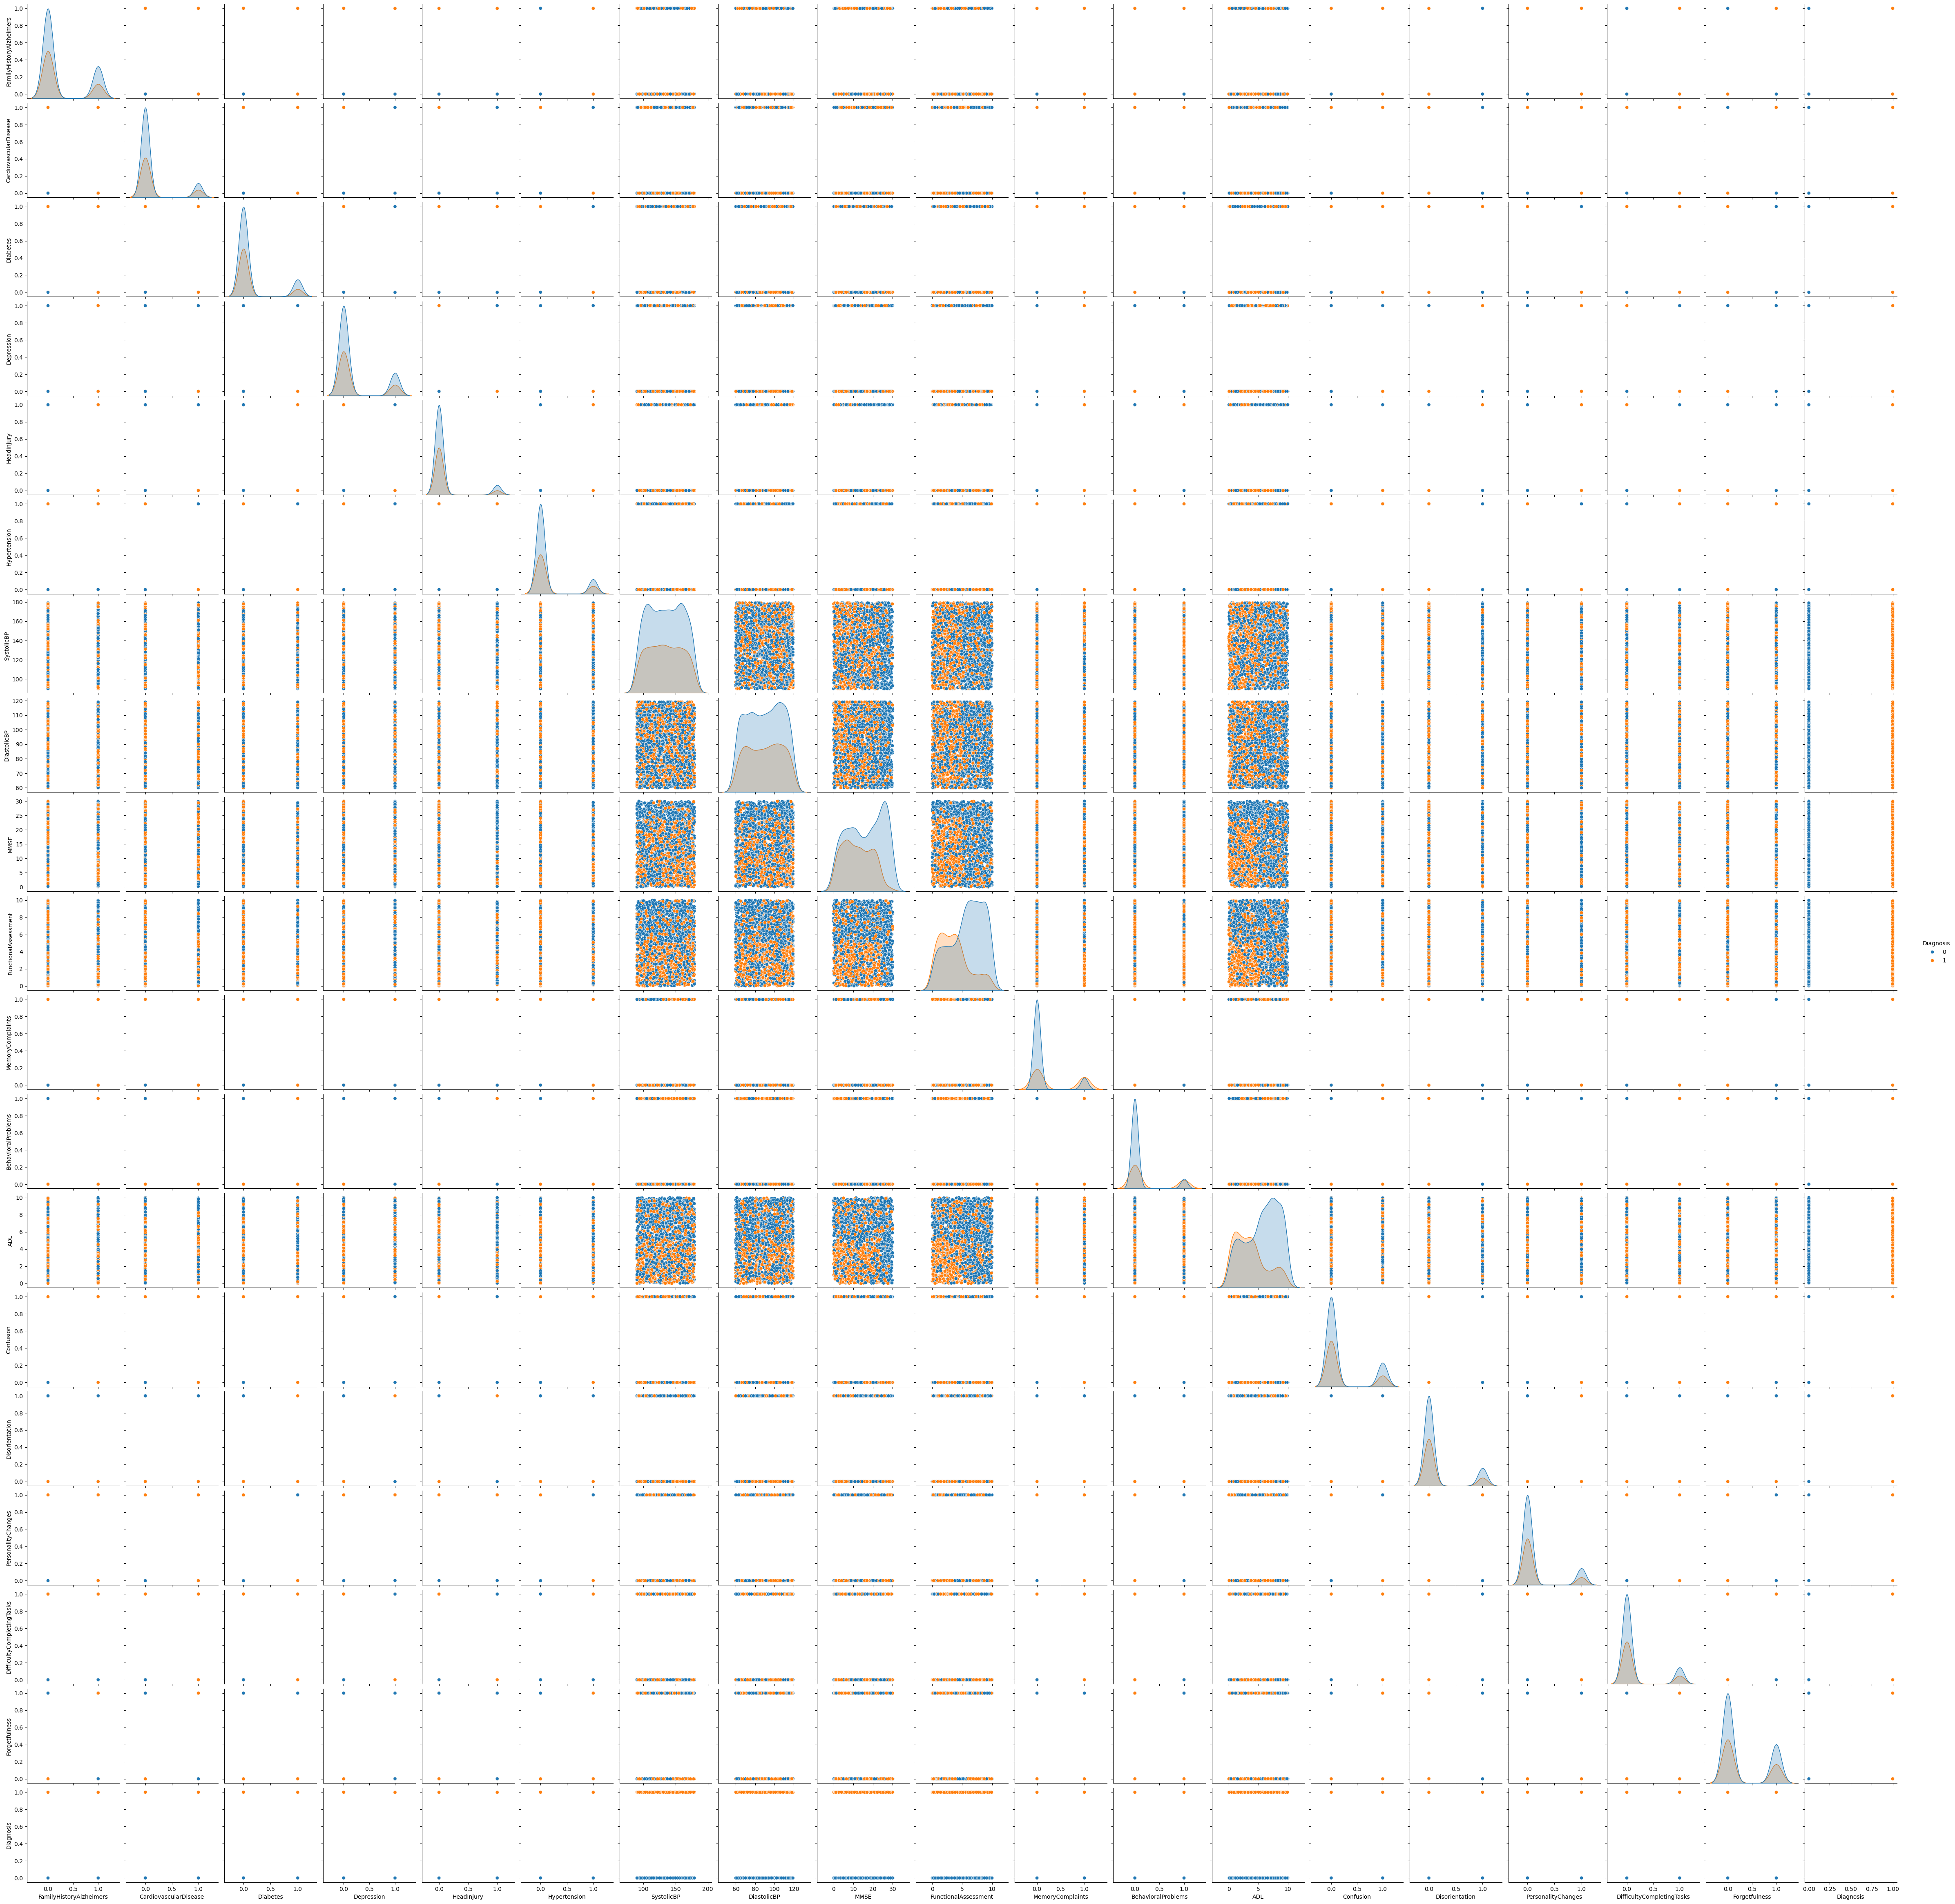

In [4]:
sns.pairplot(df, hue='Diagnosis', vars=['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
       'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP',
       'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation',
       'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'])

<Axes: >

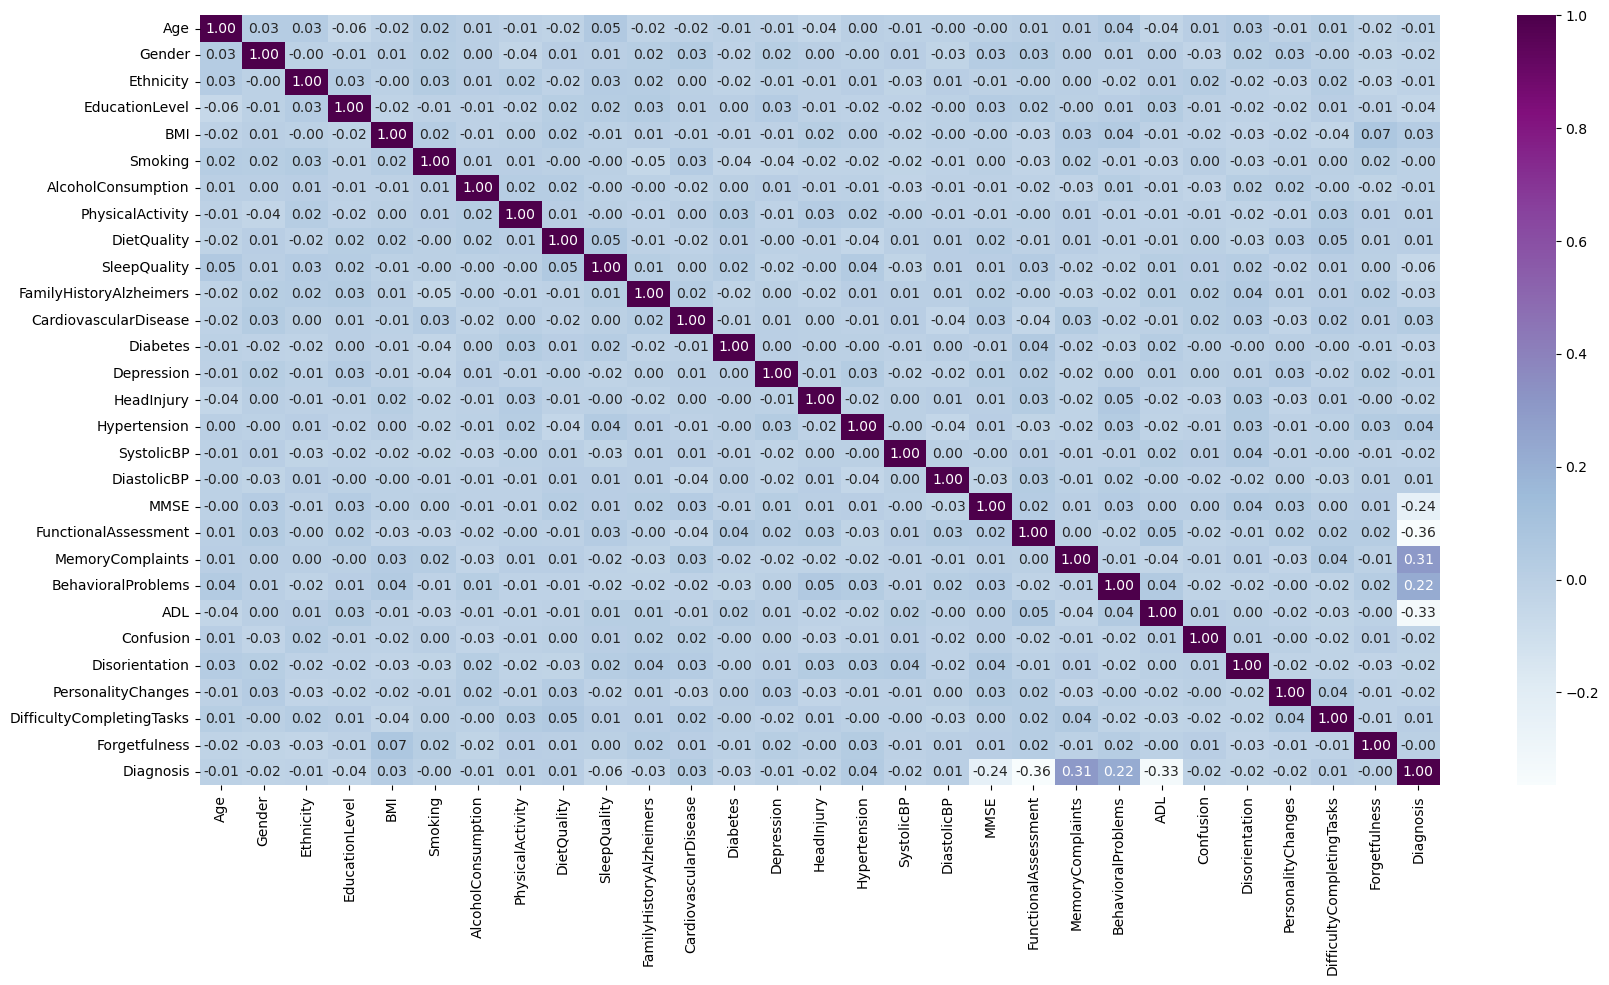

In [5]:
corr_matrix_pearson = df.corr(numeric_only=True)
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix_pearson, annot=True, cmap="BuPu", fmt=".2f")

In [6]:
clf = svm.SVC(kernel='linear', C=100)
clf.fit(X_train, Y_train)

predict = clf.predict(X_test)
print("Accuracy is", accuracy_score(Y_test, predict)*100)

Accuracy is 80.93023255813954


In [7]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.01, 0.1, 0.5, 1, 10, 100],
    'gamma': [0.001, 0.005, 0.01, 0.1, 1]
}

In [8]:
optimal_clf = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, scoring='accuracy')
optimal_clf.fit(X_train, Y_train)

print("Best Hyperparameters:", optimal_clf.best_params_)
print("Best Accuracy:", optimal_clf.best_score_)

optimal_predict = optimal_clf.predict(X_test)
print("Accuracy is", accuracy_score(Y_test, optimal_predict)*100)

Best Hyperparameters: {'C': 10, 'gamma': 0.005, 'kernel': 'rbf'}
Best Accuracy: 0.8616921373200442
Accuracy is 81.86046511627907


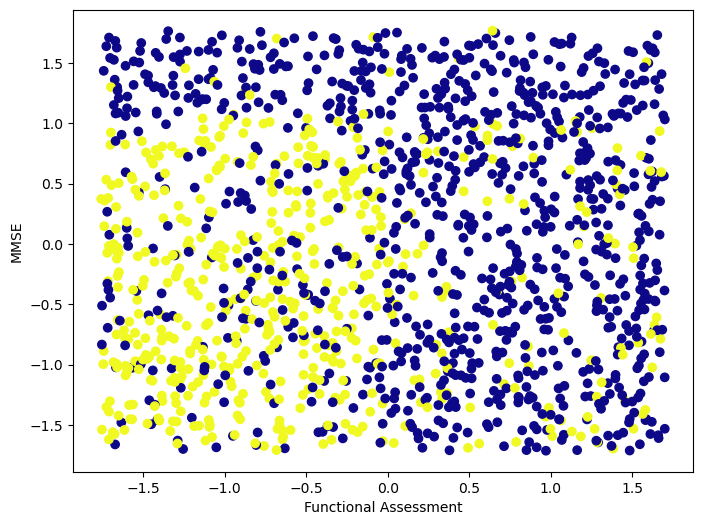

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_train.loc[:, 'FunctionalAssessment'], X_train.loc[:, 'MMSE'], c=Y_train, cmap='plasma')
plt.xlabel('Functional Assessment')
plt.ylabel('MMSE')
plt.show()

In [10]:
pca_clf = svm.SVC(kernel='linear', C=1, gamma=0.01)
pca_clf.fit(pca_train, Y_train)

pca_predict = pca_clf.predict(pca_test)
print("Accuracy is", accuracy_score(Y_test, pca_predict)*100)

Accuracy is 68.37209302325581


In [11]:
optimal_clf_pca = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, scoring='accuracy')
optimal_clf_pca.fit(pca_train, Y_train)

print("Best Hyperparameters:", optimal_clf_pca.best_params_)
print("Best Accuracy:", optimal_clf_pca.best_score_)

optimal_pca_predict = optimal_clf_pca.predict(pca_test)
print("Accuracy is", accuracy_score(Y_test, optimal_pca_predict)*100)

Best Hyperparameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Best Accuracy: 0.6303189368770764
Accuracy is 68.37209302325581


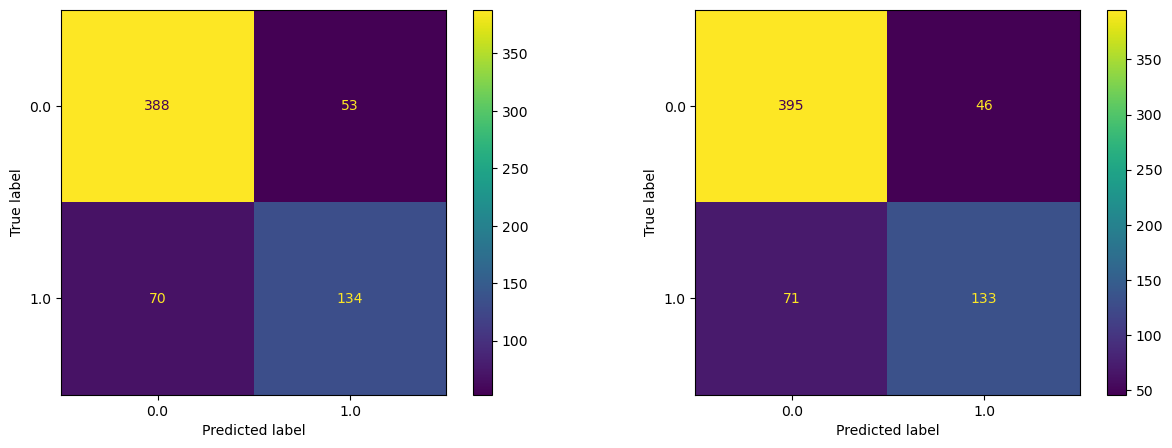

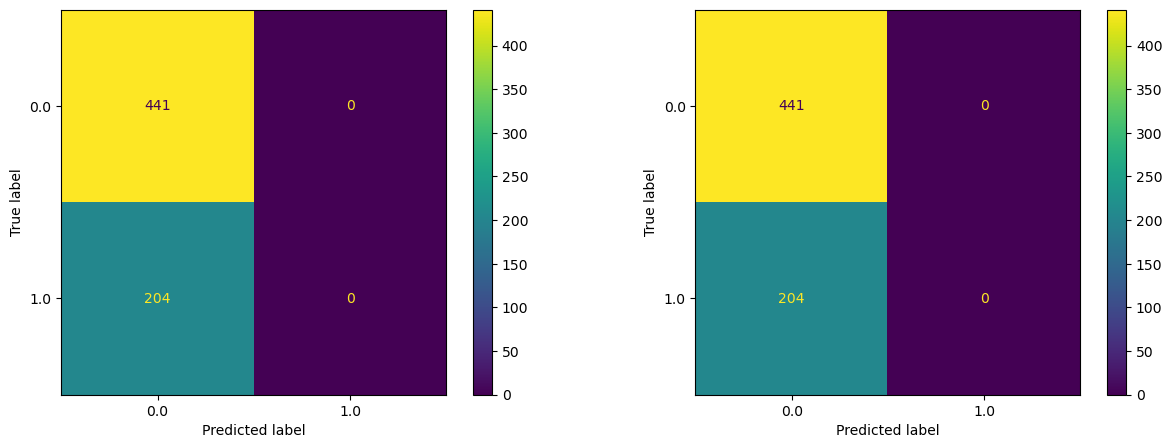

In [12]:
classifiers = [clf, optimal_clf]
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
for ax, classifier in zip(axs, classifiers):
    disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

pca_classifiers = [pca_clf, optimal_clf_pca]
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
for ax, classifier in zip(axs, pca_classifiers):
    disp = ConfusionMatrixDisplay.from_estimator(classifier, pca_test, Y_test, ax=ax)
plt.show()

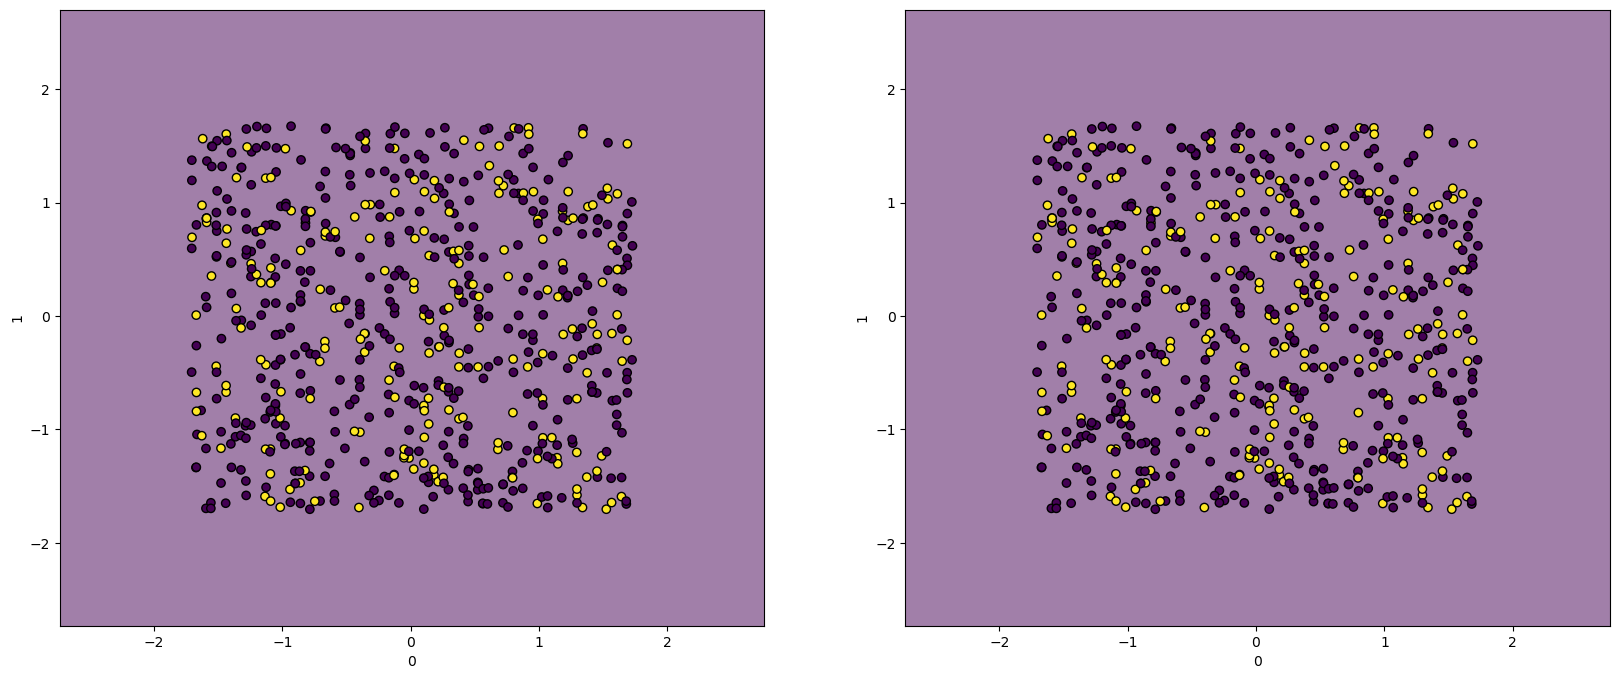

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
for ax, classifier in zip(axs, pca_classifiers):
    disp = DecisionBoundaryDisplay.from_estimator(
        pca_clf,
        pca_test,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(pca_test.loc[:, 0], pca_test.loc[:, 1], c=Y_test, edgecolors="k")
plt.show()